# Markov chains for gradient estimation in the context of Restricted Boltzman Machine Learning

_Authors: Alan García and Sandra Burgos_

notebook explanation...

## Packages

In [6]:
# Main packages for the implementation
import gzip
import numpy as np
from abc import ABC, abstractmethod
import pickle
import os

# Just for working with datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches

# For plotting
import matplotlib.pyplot as plt

In [25]:
np.random.seed(42) # For reproducibility

## Datasets

For the development and testing of the RBM implementations the MNIST handwritten numbers dataset has been used...

In [26]:
class MNIST:
    """
    https://yann.lecun.com/exdb/mnist/
    ubyte format of MNIST images:
        [offset] [type]          [value]          [description]
        0000     32 bit integer  0x00000803(2051) magic number
        0004     32 bit integer  10000            number of images
        0008     32 bit integer  28               number of rows
        0012     32 bit integer  28               number of columns
        0016     unsigned byte   ??               pixel
        0017     unsigned byte   ??               pixel
        ........
        xxxx     unsigned byte   ??               pixel
    
    ubyte format of MNIST labels:
        [offset] [type]          [value]          [description]
        0000     32 bit integer  0x00000801(2049) magic number (MSB first)
        0004     32 bit integer  60000            number of items
        0008     unsigned byte   ??               label
        0009     unsigned byte   ??               label
        ........
        xxxx     unsigned byte   ??               label
    """
    
    def __init__(self, images_path: str, label_path: str, N: int = None) -> None:
        """
            INPUT:
                - images path: path of the dataset images
                - labels path: path of the dataset labels
                - N: if not provided, all the images in the input file are read.
                    Else, N images are read.
        """
        
        self.images_path = images_path
        self.labels_path = label_path

        # Open with gzip to uncompress the files
        self.images_file = gzip.open(self.images_path, "rb")
        self.labels_file = gzip.open(self.labels_path, "rb")
        self.images_file.read(4) # Ignore the magic numbers
        self.labels_file.read(4)

        # Prepare Images data file reader
        self.number_of_items = int.from_bytes(self.images_file.read(4), byteorder="big") # Total number of images
        self.row_num = int.from_bytes(self.images_file.read(4), byteorder="big")    # row pixels of image
        self.col_num = int.from_bytes(self.images_file.read(4), byteorder="big")    # col pixels of image
        
        self.N = self.number_of_items if N is None else N # Number of items to be read
        self.num_bytes_per_image = self.col_num * self.row_num
        self.returned_images = 0    # Number of read images
        self.images_file.seek(16)   # Set the cursor to the init of the first image

        # Prepare Labels file reader
        assert self.number_of_items == int.from_bytes(self.labels_file.read(4), byteorder="big")
        self.labels_file.seek(8)

        # Print metadata
        print(f"[MNIST]     image size: {self.col_num}x{self.row_num} total dataset images: {self.number_of_items} images to be read: {self.N}")

        

    def __iter__(self):
        """Create an iterator for the MNIST dataset"""
        return self

    def __next__(self):
        """Return the next image in the dataset"""
        if self.returned_images >= self.N:
            self.images_file.close()
            self.labels_file.close()
            raise StopIteration
        else:
            pixels = []
            for _ in range(self.num_bytes_per_image):
                data = self.images_file.read(1)

                if not data:
                    print(f"[MNIST]     ERROR -> This should not be reached")
                    self.file.close()
                    raise StopIteration
                
                pixels.append(int.from_bytes(data, byteorder="big"))
            label = int.from_bytes(self.labels_file.read(1))
            self.returned_images += 1

            pixels = np.array(pixels)
            pixels = pixels / 255 # Normalize data 
            pixels = np.where(pixels > 0.5, 1, 0) # Transform to binary
            return pixels.tolist(), label

    def __del__(self):
        # Close the files if the object is destroyed
        if hasattr(self, 'images_file') and not self.images_file.closed:
            self.images_file.close()
        if hasattr(self, 'labels_file') and not self.labels_file.closed:
            self.labels_file.close()

    def to_list(self):
        return list(self)
    
    def to_numpy(self):
        dataset = self.to_list()
        X = np.array([item[0] for item in dataset])
        Y = np.array([item[1] for item in dataset])
        return X, Y

The `MNIST` class is just a helper to load the encoded MNIST Dataset from the `./data/` folder....

[MNIST]     image size: 28x28 total dataset images: 10000 images to be read: 10


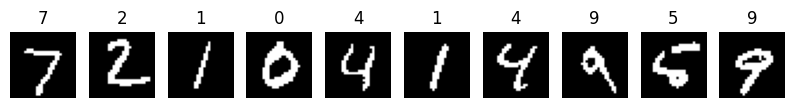

In [27]:
def MNIST_test():
    # Read the 10 first images from the MNIST dataset
    dataset = MNIST("./data/t10k-images-idx3-ubyte.gz", "./data/t10k-labels-idx1-ubyte.gz", 10)

    # Iterate the dataset
    images = []
    for img, label in dataset:
        images.append((img, label))

    # Show the result
    fig, axes = plt.subplots(1, len(images), figsize=(10, 2))
    for i in range(len(images)):
        img = np.array(images[i][0]).reshape(28, 28)
        axes[i].set_title(f"{images[i][1]}")
        axes[i].imshow(img, cmap="gray")  # Redimensiona cada imagen a 28x28
        axes[i].axis("off")  # Oculta los ejes

    plt.show()

MNIST_test()

In [28]:
dataset_train       = MNIST("./data/train-images-idx3-ubyte.gz", "./data/train-labels-idx1-ubyte.gz")
dataset_test        = MNIST("./data/t10k-images-idx3-ubyte.gz", "./data/t10k-labels-idx1-ubyte.gz")
X_train, Y_train    = dataset_train.to_numpy()
X_test, Y_test      = dataset_test.to_numpy()

[MNIST]     image size: 28x28 total dataset images: 60000 images to be read: 60000
[MNIST]     image size: 28x28 total dataset images: 10000 images to be read: 10000


## RBM Base

This is the main class of our implementation...

In [29]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def kl_divergence(p, q):
    """
    The KL-Divergence measures how different are two probability distributions
    over the same variable. 
    """ 
    assert len(p) == len(q)
    q[q == 0] = 0.00000001 # Not let any element of q be 0
    return sum(p[i] * np.log2(p[i] / q[i]) for i in range(len(p)) if p[i] > 0)

In [31]:
class RBM(ABC):
    """
        Implementation of Restricted Boltzman Machine for
        KISA Optimization Techniques by Sandra Burgos and
        Alan Garcia.
        
        References:
            - https://es.wikipedia.org/wiki/M%C3%A1quina_de_Boltzmann_restringida
            - https://upcommons.upc.edu/bitstream/handle/2117/344139/TFM.pdf?sequence=2&isAllowed=y

        Other resources for implementation:
            1. https://leftasexercise.com/2018/04/09/restricted-boltzmann-machines/
            2. https://leftasexercise.com/2018/04/13/learning-algorithms-for-restricted-boltzmann-machines-contrastive-divergence/
            3. https://leftasexercise.com/2018/04/20/training-restricted-boltzmann-machines-with-persistent-contrastive-divergence/ 
            4. https://christian-igel.github.io/paper/TRBMAI.pdf
    """
    def __init__(self, visible_nodes, hidden_nodes, k: int = 1, pretrained: str = None) -> None:
        """
            n_v: number of visible nodes
            n_h: number of hidden nodes
            k -> Number of gibbsampling steps to be performed    
            pretrained: path of a rbm model checkpoint to load

            W -> Network weights
            a -> Visible layer biases
            b -> Hidden layer biases
        """
        
        if pretrained:
            self._load(pretrained)
        else:
            self.n_v = visible_nodes
            self.n_h = hidden_nodes
            self.k = k 
    
            # Initialize random weights from uniform distribution (Xavier initialization)
            limit = np.sqrt(6. / (self.n_v + self.n_h))
            self.W = np.random.uniform(low=-limit, high=limit, size=(self.n_v, self.n_h))
            self.a = np.random.uniform(low=-limit, high=limit, size=(self.n_v)) # np.zeros((1, visible_nodes))
            self.b = np.random.uniform(low=-limit, high=limit, size=(self.n_h)) # np.zeros((1, hidden_nodes))
    
    def _load(self, filename:str):
        """
            Load the params from a pretrained model 
        """
        f = open(filename, 'rb')
        tmp_dict = pickle.load(f)
        f.close()          

        self.__dict__.update(tmp_dict) 

    def save(self, filename:str):
        """
            Save the model params
        """
        base, ext = os.path.splitext(filename)  # Separate name and extension
    
        # Check if the file exists
        while os.path.exists(filename):
            filename = f"{base}_({i}){ext}"
            i += 1

        f = open(filename, 'wb')
        pickle.dump(self.__dict__, f, 2)
        f.close()

    def _forward(self, V):
        """ 
            Fordward propagation:
            Activation probability 
                > P(hj = 1 | v) = S (bj + sum_i=1^m(Wi,j * vi) )
                    where S is the sigmoid function, v the visible layers set and h the hidden layers set
                > P(h | v) = S( b + v @ W)
        """
        # V: (N, visible_nodes)
        h_p = np.dot(V, self.W) + self.b
        h_p = sigmoid(h_p)
        assert h_p.shape == (V.shape[0], self.n_h)

        h = np.random.binomial(1, h_p, size=h_p.shape)
        return h_p, h
    
    def _backward(self, H):
        """
            Backward:
            Activation probability > P(vi = 1 | h) = S (ai + sum_j=1^m(Wi,j * hj) )
                where S is the sigmoid function, v the visible layers set and h the hidden layers set
        """
        # V: (N, hidden_nodes)
        v_p = np.dot(H, self.W.T) + self.a
        v_p = sigmoid(v_p)
        assert v_p.shape == (H.shape[0], self.n_v)

        v = np.random.binomial(1, v_p, size=v_p.shape)
        return v_p, v

    def _gibbsampling(self, V):
        """
            Perform Gibbsampling
            OUTPUT: (h_p, h, v_p_, v_)
                h_p: hidden layer activation probs
                h: hidden layer samples
                v_p_: visible layer activation probs
                v_: visible layer reconstruction
        """
        v = V
        for i in range(self.k):
            h_p, h = self._forward(v)
            v_p, v = self._backward(h)
        return h_p, h, v_p, v

    @abstractmethod
    def fit():
        """
        The objective is to minimize the energy E of the system:
            E(v, h)=-a' v - b' h - v' W h
        So, to train the RBM we need to compute these terms:
            ∂Energy(v, h)/∂Wij = −hi · vj
            ∂Energy(v, h)/∂bj = −vj
            ∂Energy(v, h)/∂ci = −hi
        However, we don't have access to v and h but we have access
        to ther probabilities p_v and p_h, so we have to sample from
        P(v | h) and P(h | v)
        But direct sampling from those distributions is hard, thats why 
        CD, PCD and other methods were developed
        """
        raise NotImplemented

    def reconstruct(self, X):
        """
            Gibbsampling step to reconstruct output vk from v0 input.
            OUTPUT: generated visible layer output
        """
        h_p, h, v_p_, v_  = self._gibbsampling(X)
        return v_

In [32]:
# Example data input
v = np.array([
    [0.001, 1, 0.001, 1]
    ])

# Instantiate the RBM test object
class RBM_BASE(RBM):
    def __init__(self, visible_nodes, hidden_nodes):
        super().__init__(visible_nodes, hidden_nodes)
    def fit():
        # Train not implemented for just testing 
        # the vissible and hidden layers
        pass
rbm = RBM_BASE(4, 2)
p_h, h = rbm._forward(v)

print("RBM BASE TEST")
print(f"Test input shape: {v.shape} Test input: \n{v}")
print(f"rbm visible nodes: {rbm.n_v} hidden nodes: {rbm.n_v}")
print(f"rbm.a biasses shape: {rbm.a.shape} rbm.a biasses: \n{rbm.a}")
print(f"rbm.b biasses shape: {rbm.b.shape} rbm.b biasses: \n{rbm.b}")
print(f"rbm.W weights shape: {rbm.W.shape} rbm.W weights: \n{rbm.W}")
print(f"rbm forward shape{p_h.shape} rbm forward out: \n{p_h}")

p_v, v = rbm._backward(p_h)
print(f"rbm backward shape{p_v.shape} rbm backward out: \n{p_v}")

v_ = rbm.reconstruct(v)
print(f"rbm reconstruct process for v input and {rbm.k} gibbsampling steps: \n{v_}")
    
# The goal is to reduce the divergence between the input probability
# dsitribution and the output. 
# v = np.array([1, 0.001, 0.001, 1])
# v_ = np.array([1, 1, 1, 1])
# kld = 0.98860 >> 0 -> significant divergence
kld = kl_divergence(v.flatten() / np.sum(v.flatten()), v_.flatten() / np.sum(v_.flatten()))
print(f"KL-Divergence between input and final RBM probability output: {kld}")
print("===================================")
print()

RBM BASE TEST
Test input shape: (1, 4) Test input: 
[[0.001 1.    0.001 1.   ]]
rbm visible nodes: 4 hidden nodes: 4
rbm.a biasses shape: (4,) rbm.a biasses: 
[ 0.20223002  0.41614516 -0.95883101  0.9398197 ]
rbm.b biasses shape: (2,) rbm.b biasses: 
[ 0.66488528 -0.57532178]
rbm.W weights shape: (4, 2) rbm.W weights: 
[[-0.25091976  0.90142861]
 [ 0.46398788  0.19731697]
 [-0.68796272 -0.68801096]
 [-0.88383278  0.73235229]]
rbm forward shape(1, 2) rbm forward out: 
[[0.56072415 0.58772315]]
rbm backward shape(1, 4) rbm backward out: 
[[0.64366881 0.68832114 0.1481799  0.70571312]]
rbm reconstruct process for v input and 1 gibbsampling steps: 
[[1 1 0 0]]
KL-Divergence between input and final RBM probability output: 7.940179085645143



## RBM Contrastive Divergence

Here it is the implementation of the Contrastive Divergence algorithm for training Restricted Boltzman Machines...

In [33]:

class RBM_CD(RBM):
    def __init__(self, visible_nodes, hidden_nodes, k: int = 1) -> None:
       super().__init__(visible_nodes, hidden_nodes, k)
    
    def _contrastive_divergence(self, batch, batch_size, lr):  
        """
            K-Step Contrastive Divergence Algorithm
        """      
        v = batch
        h_p, h, v_p_, v_ = self._gibbsampling(v)
        h_p_, h_ = self._forward(v_)
        
        # v_p_, v_, h_p_ and h_ are on the negative phase
        possitive_association = np.dot(v.T, h_p)
        negative_association = np.dot(v_.T, h_p_)
        
        
        # Update the parameters
        # W += lr * (possitive_associations - negative_associations)
        # possitive_associations = v • p_v
        # negative_associations = vk • p_vk
        self.W += lr * (possitive_association - negative_association) / batch_size
        self.a += lr * np.mean(v - v_, axis=0)
        self.b += lr * np.mean(h_p - h_p_, axis=0)
        
        #Compute loss for the instance
        error = np.sum((v - v_)**2) / batch_size
        return error
   
    def fit(self, X, epochs = 10, batch_dim = 32, lr = 0.01, verbose = False) -> list:
        """
             Train the RBM using Contrastive Divergence
        """
        train_errors = []
        for epoch in range(epochs):
            t_error = 0.0
            train_num = X.shape[0]
            batches = list(gen_batches(train_num, batch_dim))
            for batch in batches:
                batch = X[batch.start:batch.stop]
                batch_size = batch.shape[0]

                error = self._contrastive_divergence(batch, batch_size, lr)
                t_error += error
            
            t_error /= len(batches)
            train_errors.append(t_error)
            if verbose:
                print(f"epoch: {epoch}/{epochs} \t{'error:'} {t_error}")
        
        return train_errors

### XOR Function Modeling with CD RMB

Let's try to model a XOR logic gate using the Contrastive Divergence RBM we have already implemented.
To make this, we will set the train set as all the posible inputs/output of the XOR gate and then we will try to give the RBM an impossible input for the XOR logic and check if the reconstructed input follows the internal distribution of the XOR gate.

The hipotesis here is that as the Restricted Boltzman Machine has the hability to learn the distribution of a given set, when it is exposed to data that hasn't seen before it will try to adapt that input to it's already learned distribution. 

In [34]:
# Train data
xor_logic = np.array([
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0],
    [1, 1, 1],
])

# Hyperparameters
k_gibbs_steps   = 5
learning_rate   = 0.0001
hidden_nodes    = 2     # Number of visible nodes are the input shape
epochs          = 10    # Number of epochs

In [37]:
# Instantiate the RBM object
rbm = RBM_CD(xor_logic.shape[1], hidden_nodes, k=k_gibbs_steps)

# Print some information about the matrix shapes
print("RBM CD FUNCTION APROXIMATION TEST")
print(f"XOR logic set shape: {xor_logic.shape}\t XOR logic:\n{xor_logic}")
print(f"rbm visible nodes: {rbm.n_v} hidden nodes: {rbm.n_v}")
print(f"rbm.a biasses shape: {rbm.a.shape} rbm.a biasses: \n{rbm.a}")
print(f"rbm.b biasses shape: {rbm.b.shape} rbm.b biasses: \n{rbm.b}")
print(f"rbm.W weights shape: {rbm.W.shape} rbm.W weights: \n{rbm.W}")

RBM CD FUNCTION APROXIMATION TEST
XOR logic set shape: (4, 3)	 XOR logic:
[[0 0 1]
 [0 1 0]
 [1 0 0]
 [1 1 1]]
rbm visible nodes: 3 hidden nodes: 3
rbm.a biasses shape: (3,) rbm.a biasses: 
[ 0.21448811  0.92428014 -0.90156776]
rbm.b biasses shape: (2,) rbm.b biasses: 
[-0.66606818 -0.99635709]
rbm.W weights shape: (3, 2) rbm.W weights: 
[[ 0.10233709 -0.69044929]
 [ 1.02880837  0.60278581]
 [ 0.96289394  0.86502338]]


In [38]:
rbm.fit(xor_logic, epochs=epochs, batch_dim=1, lr=learning_rate, verbose=True)

print(f"Final rbm.a biasses: \n{rbm.a}")
print(f"Final rbm.b biasses: \n{rbm.b}")
print(f"Final rbm.W weights: \n{rbm.W}")

epoch: 0/10 	error: 1.5
epoch: 1/10 	error: 2.25
epoch: 2/10 	error: 1.75
epoch: 3/10 	error: 2.25
epoch: 4/10 	error: 0.75
epoch: 5/10 	error: 1.75
epoch: 6/10 	error: 2.0
epoch: 7/10 	error: 1.5
epoch: 8/10 	error: 2.5
epoch: 9/10 	error: 1.25
Final rbm.a biasses: 
[ 0.21488811  0.92268014 -0.90216776]
Final rbm.b biasses: 
[-0.66609732 -0.99638266]
Final rbm.W weights: 
[[ 0.10256821 -0.69013989]
 [ 1.02757825  0.60199702]
 [ 0.96231539  0.86453684]]


Here `v` is an impossible state of a XOR logic gate were `x1 = x2 = 1` and the output is `y = 0` where it should be `y = 1`

In [39]:
# Recontruction
v = np.array([[1, 1, 0]]) # This is not possible for XOR function
v_ = rbm.reconstruct(v)
print(f"Impossible inut: {v}") 
print(f"Reconstructed output: {v_}")

Impossible inut: [[1 1 0]]
Reconstructed output: [[0 1 0]]


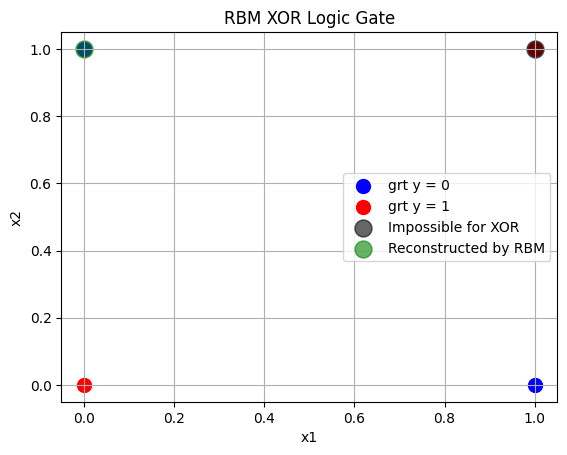

In [40]:
# Plot the results with matplotlib
grt_color_map = { 0: "blue", 1: "red" } # Ground_truth color map
rbm_color_map = { 0: "blue", 1: "red" } # RBM prediction color map

# Ground truth
grt_xor_0 = xor_logic[xor_logic[:, 2] == 0]
grt_xor_1 = xor_logic[xor_logic[:, 2] == 1]
plt.scatter(grt_xor_0[:, 0], grt_xor_0[:, 1], s = 100, color = grt_color_map[0], label = "grt y = 0", )
plt.scatter(grt_xor_1[:, 0], grt_xor_1[:, 1], s = 100, color = grt_color_map[1], label = "grt y = 1", )
    
# Reconstruction    
plt.scatter(v[:, 0], v[:, 1], s = 150, color = "black", label = "Impossible for XOR", alpha=0.6)
plt.scatter(v_[:, 0], v_[:, 1], s = 150, color = "green", label = "Reconstructed by RBM", alpha=0.6)

# Show
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("RBM XOR Logic Gate")
plt.grid()
plt.legend()
plt.show()

### MNIST Data Reconstruction with CD RBM

In [42]:
# Hyperparameters
k = 1
batch_size    = 64
learning_rate = 0.1
hidden_nodes  = 30      # Number of visible nodes are the input shape
epochs        = 100     # Number of epochs

print("RBM CD MNIST RECONSTRUCTION TEST")
print(f"Hyperparameters:")
print(f"\tX_train instances: {X_train.shape[0]}\tX_test instances: {X_test.shape[0]}")
print(f"\tbatch size: {batch_size}\tepochs: {epochs}\tlearning rate: {learning_rate}")
print(f"\tvisible nodes: {X_train.shape[1]}\thidden nodes:{hidden_nodes}")

RBM CD MNIST RECONSTRUCTION TEST
Hyperparameters:
	X_train instances: 60000	X_test instances: 10000
	batch size: 64	epochs: 100	learning rate: 0.1
	visible nodes: 784	hidden nodes:30


In [45]:
# Initialize RBM with 30 hidden units and train it for 100 epochs
rbm = RBM_CD(visible_nodes=X_train.shape[1], hidden_nodes=hidden_nodes, k=k)

print("Train:")
rbm.fit(X_train, epochs=epochs, batch_dim=batch_size, lr=learning_rate, verbose=True)

epoch: 0/100 	error: 102.13631063432835
epoch: 1/100 	error: 81.58896921641791
epoch: 2/100 	error: 77.43566764392324
epoch: 3/100 	error: 75.67487340085287
epoch: 4/100 	error: 74.83580423773988
epoch: 5/100 	error: 74.3315565031983
epoch: 6/100 	error: 74.06010127931769
epoch: 7/100 	error: 73.77690231876332
epoch: 8/100 	error: 73.66721082089552
epoch: 9/100 	error: 73.55228877931769
epoch: 10/100 	error: 73.416677771855
epoch: 11/100 	error: 73.29247734541578
epoch: 12/100 	error: 73.06188366204691
epoch: 13/100 	error: 72.95550706289978
epoch: 14/100 	error: 72.82660914179104
epoch: 15/100 	error: 72.80946828358209
epoch: 16/100 	error: 72.80908515458422
epoch: 17/100 	error: 72.67877132196162
epoch: 18/100 	error: 72.63014725479744
epoch: 19/100 	error: 72.53776319296375
epoch: 20/100 	error: 72.45170908848614
epoch: 21/100 	error: 72.4025019989339
epoch: 22/100 	error: 72.27671908315565
epoch: 23/100 	error: 72.24978344882729
epoch: 24/100 	error: 72.152601945629
epoch: 25/100 	

Perform the RBM reconstruction over a restricted set from the `test_set` where there is one example of each label and then show the results

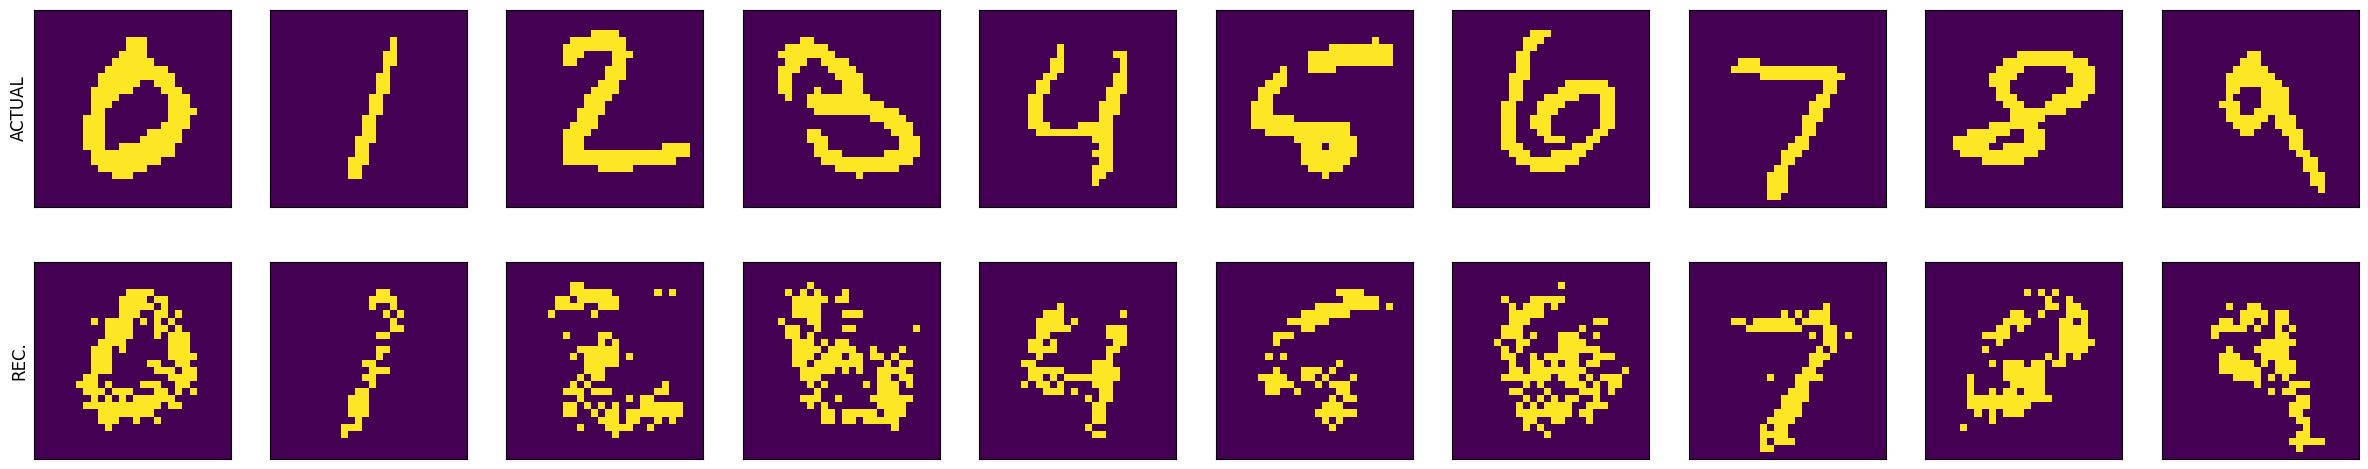

In [46]:
# reconstruction
digit_indices = [np.where(Y_test == i)[0][0] for i in range(10)]
resticted_set = X_test[digit_indices]

reconstructed = rbm.reconstruct(resticted_set)

# show 10 sample images
rows = 2
columns = 10

fig, axes = plt.subplots(rows, columns,sharey = True,figsize=(30, 6))
for i in range(rows):
    for j in range(columns):
        if i==0:
          axes[i, j].imshow(resticted_set[j].reshape(28, 28))
        else:
          axes[i, j].imshow(reconstructed[j].reshape(28, 28))

        axes[i, j].tick_params(left = False, right = False , labelleft = False,
                labelbottom = False, bottom = False)

axes[0, 0].set_ylabel("ACTUAL", fontsize=12)
axes[1, 0].set_ylabel("REC.", fontsize=12)
plt.show()

## RBM Persistent Contrastive Divergence

Here it is the implementation of the Persisten Contrastive Divergence algorithm...

In [41]:
class RBM_PCD(RBM):
    def __init__(self, visible_nodes, hidden_nodes, batch_size = 32, k: int = 2) -> None:
        super().__init__(visible_nodes, hidden_nodes, k)
        self.current_step = 0 # For learning rate decay

        # Initialize the visible persistent values
        self.visible_persistent = np.random.binomial(1, 0.5, size=(batch_size, self.n_v))  
    
    def _persistent_contrastive_divergence(self, batch, batch_size, lr, weight_decay):
        """
            K-Step Parallel Tempering Algorithm
        """
        
        v = batch
        v_persistent = self.visible_persistent

        h_p, _= self._forward(v)
        _, _, _, v_persistent_ = self._gibbsampling(v_persistent)
        h_p_persistent_, _ = self._forward(v_persistent_)

        possitive_association = np.dot(v.T, h_p)
        negative_association = np.dot(v_persistent_.T, h_p_persistent_)
        
        # Update the parameters
        self.W += lr * (possitive_association - negative_association) / batch_size  - weight_decay * self.W / batch_size
        self.a += lr * np.mean(v - v_persistent_, axis=0)
        self.b += lr * np.mean(h_p - h_p_persistent_, axis=0)
        self.visible_persistent = v_persistent_

        #Compute loss for the instance
        error = np.sum((v - self.visible_persistent)**2) / batch_size
        return error

    def fit(self, X, epochs = 10, batch_dim = 32, lr = 0.1, weight_decay = 0.001, verbose = False) -> list:
        """
            Train the RBM using Persistent Contrastive Divergence
        """
        self.current_step = 0 # lr linear decay

        train_errors = []
        for epoch in range(epochs):
            t_error = 0.0
            train_num = X.shape[0]
            batches = list(gen_batches(train_num, batch_dim))
            for batch in batches:
                batch = X[batch.start:batch.stop]
                batch_size = batch.shape[0]
                
                if batch_size != batch_dim:
                    continue # skip

                # Linear learning rate decay
                learning_rate = lr
                # learning_rate = lr *(1 - self.current_step / (batch_size * len(batches) * epochs))
                # self.current_step += 1

                t_error += self._persistent_contrastive_divergence(batch, batch_size, learning_rate, weight_decay)
           
            t_error /= len(batches)
            train_errors.append(t_error)
            
            if verbose:
                print(f"epoch: {epoch}/{epochs} \t{'error:'} {t_error}")
        return train_errors

### MNIST Data Reconstruction with PCD RBM

In [ ]:

# Hyperparameters
k = 1
batch_size    = 64
learning_rate = 0.1
hidden_nodes  = 30      # Number of visible nodes are the input shape
epochs        = 100     # Number of epochs

# Load some instances of the dataset
dataset_train       = MNIST("./data/train-images-idx3-ubyte.gz", "./data/train-labels-idx1-ubyte.gz")
dataset_test        = MNIST("./data/t10k-images-idx3-ubyte.gz", "./data/t10k-labels-idx1-ubyte.gz")
X_train, Y_train    = dataset_train.to_numpy()
X_test, Y_test      = dataset_test.to_numpy()
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42, stratify=Y)

# Initialize RBM with 30 hidden units
rbm = RBM_PCD(visible_nodes=X_train.shape[1], hidden_nodes=hidden_nodes, batch_size=batch_size, k= k)

# Test
print("RBM PCD MNIST RECONSTRUCTION TEST")
print(f"Hyperparameters:")
print(f"\tX_train instances: {X_train.shape[0]}\tX_test instances: {X_test.shape[0]}")
print(f"\tbatch size: {batch_size}\tepochs: {epochs}\tlearning rate: {learning_rate}")
print(f"\tvisible nodes: {X_train.shape[1]}\thidden nodes:{hidden_nodes}")
print(f"Training:")
rbm.fit(X_train, epochs=epochs, batch_dim=batch_size, lr=learning_rate)
rbm.save(f"./models/RBM_PCD_e{epochs}_bt{batch_size}_lr{learning_rate}_hn{hidden_nodes}_k{k}.pt")


# reconstruction
digit_indices = [np.where(Y_test == i)[0][0] for i in range(10)]
resticted_set = X_test[digit_indices]

reconstructed = rbm.reconstruct(resticted_set)

# show 10 sample images
rows = 2
columns = 10

fig, axes = plt.subplots(rows, columns,sharey = True,figsize=(30, 6))
for i in range(rows):
    for j in range(columns):
        if i==0:
          axes[i, j].imshow(resticted_set[j].reshape(28, 28))
        else:
          axes[i, j].imshow(reconstructed[j].reshape(28, 28))

        axes[i, j].tick_params(left = False, right = False , labelleft = False,
                labelbottom = False, bottom = False)

axes[0, 0].set_ylabel("ACTUAL", fontsize=12)
axes[1, 0].set_ylabel("REC.", fontsize=12)
plt.show()

print("===================================")
print()